# Group Analysis of ERP Data

## Load packages

In [1]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output
import matplotlib.pyplot as plt
import numpy as np
import glob

## Define parameters

We define a list of experimental conditions; that's about the only parameter we need to define here.

In [2]:
conditions = ['Control', 'Violation']

## Find data files

We list all the `-ave.fif` files (`Evoked` data sets) associated with this experiment:

In [3]:
data_dir = 'data'
data_files = glob.glob(data_dir + '/sentence_n400_p*-ave.fif' )
data_files

['data/sentence_n400_p22-ave.fif',
 'data/sentence_n400_p14-ave.fif',
 'data/sentence_n400_p04-ave.fif',
 'data/sentence_n400_p05-ave.fif',
 'data/sentence_n400_p15-ave.fif',
 'data/sentence_n400_p23-ave.fif',
 'data/sentence_n400_p17-ave.fif',
 'data/sentence_n400_p07-ave.fif',
 'data/sentence_n400_p21-ave.fif',
 'data/sentence_n400_p20-ave.fif',
 'data/sentence_n400_p06-ave.fif',
 'data/sentence_n400_p16-ave.fif',
 'data/sentence_n400_p13-ave.fif',
 'data/sentence_n400_p03-ave.fif',
 'data/sentence_n400_p25-ave.fif',
 'data/sentence_n400_p24-ave.fif',
 'data/sentence_n400_p02-ave.fif',
 'data/sentence_n400_p12-ave.fif',
 'data/sentence_n400_p26-ave.fif',
 'data/sentence_n400_p09-ave.fif',
 'data/sentence_n400_p19-ave.fif',
 'data/sentence_n400_p10-ave.fif',
 'data/sentence_n400_p01-ave.fif',
 'data/sentence_n400_p11-ave.fif',
 'data/sentence_n400_p18-ave.fif',
 'data/sentence_n400_p08-ave.fif']

## Load data files

In the previous lesson on averaging trials for an individual participant, we ended by saving the list of MNE `Evoked` objects (representing the averages across trials for each condition) in a single file for that participant. 

Here, we will load in the files from a group of participants. To work with them easily and efficiently in MNE, we will store them as a dictionary, where each key is a condition label, and each value is a list of `Evoked` objects (the data from that condition, with each participant's `Evoked` as a list item).

Here when we `read_evokeds()` you will likewise get a list of `Evoked` objects. Lists are a bit tricky since they don't contain labels. In the previous lesson we addressed this by manually changing the `.comment` field of each `Evoked` object to clearly label it. As well, in the case of the present data (as is good practice in any data science pipeline), we used the same code to generate all of the Evoked files, so the two experimental conditions occur in the same order in each `-ave.fif` file. Since each participant's data was saved in the same order, index 0 in the list will always be the same condition for all participants. For this reason, we can use `enumerate()` to loop over conditions and build our dictionary of `Evoked` objects here.

Note that we use list comprehension to build the list of Evoked objects for each condition, and we use the index from `enumerate()` (`idx`) to specify which condition (list item) we read from each participant's data file:

In [4]:
evokeds = {}

for idx, c in enumerate(conditions):
    evokeds[c] = [mne.read_evokeds(d)[idx] for d in data_files]

evokeds

{'Control': [<Evoked | 'Control' (average, N=40), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=35), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=39), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=38), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=41), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=33), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=40), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=40), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=34), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=40), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control' (average, N=32), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
  <Evoked | 'Control'

## Compare Evoked waveforms

`mne.viz.plot_compare_evokeds()` will recognize a dictionary of Evoked objects and use the keys as condition labels. Furthermore, when it sees that each value in the dictionary is a list of Evoked objects, it will combine them and plot not only the mean across the list (i.e., across participants, for each condition), but also the 95% confidence intervals (CIs), representing the variability across participants. As we learned in the [EDA] chapter, CIs are a useful way of visually assessing whether different conditions are likely to be statistically significantly different. In this case, the plot shows evidence of an N400 effect. The difference between conditions is largest between ~350–650 ms, and the CIs are most distinct (overlapping little or not at all) between 500–650 ms.

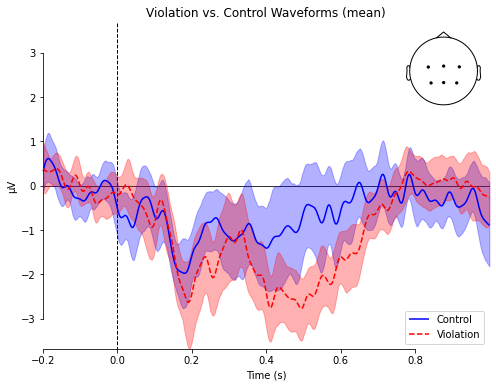

In [5]:
# Define plot parameters
roi = ['C3', 'Cz', 'C4', 
       'P3', 'Pz', 'P4']

color_dict = {'Control':'blue', 'Violation':'red'}
linestyle_dict = {'Control':'-', 'Violation':'--'}


mne.viz.plot_compare_evokeds(evokeds,
                             combine='mean',
                             legend='lower right',
                             picks=roi, show_sensors='upper right',
                             colors=color_dict,
                             linestyles=linestyle_dict,
                             title='Violation vs. Control Waveforms'
                            )
plt.show()

## Differences

As we did in the single-participant analysis, we can also create difference waves to more easily visualize the difference between conditions, and compare it to zero (i.e., no difference between conditions). 

In order to get CIs that reflect the variance across participants, we need to compute the *Violation-Control* difference separately for each participant. As we did for a single participant's data, we use `mne.combine_evoked()` for this, with a weight of `1` for *Violation* and `-1` for *Control*. The only difference here is we put this function in a loop over participants. 

In [6]:
diff_waves = []
for i in range(len(data_files)):
    diff_waves.append(mne.combine_evoked([evokeds['Violation'][i], evokeds['Control'][i]],
                                          weights=[1, -1]
                                         )
                     )

diff_waves

[<Evoked | 'Violation - Control' (average, N=20.0), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=17.74647887323944), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=18.986842105263158), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=19.0), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=19.9875), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=16.5), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=18.37837837837838), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=19.487179487179485), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violation - Control' (average, N=16.484848484848484), -0.19922 – 1 sec, baseline off, 64 ch, ~401 kB>,
 <Evoked | 'Violatio

## Plot difference waveform

In making the difference waveform above, we simply created a list of `Evoked` objects. We didn't create a dictionary since there is only one contrast (*Violation-Control*), so no need to have informative dictionary keys for a set of different items (contrasts). This is fine, however MNE's  `plot_compare_evokeds()` is a bit picky when it comes to its inputs, and whether it draws CIs or not. Specifically, the [API](https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html) reads:
> If a list of Evokeds, the contents are plotted with their .comment attributes used as condition labels... If a dict whose values are Evoked objects, the contents are plotted as single time series each and the keys are used as labels. If a [dict/list] of lists, the unweighted mean is plotted as a time series and the parametric confidence interval is plotted as a shaded area.

In other words, when the function gets a list of `Evoked` objects as input, it will draw each object as a separate waveform, but if it gets a dictionary in which each entry is a list of `Evoked` objects, if will average them together and draw CIs. Since we desire the latter behaviour here, in the command below we create a dictionary "on the fly" inside the plotting command, with a key corresponding to the label we want, and the value being the list of difference waves. 

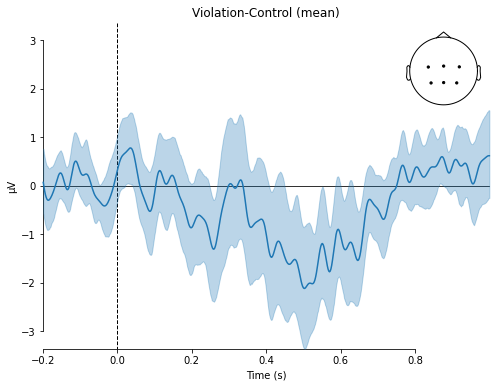

In [7]:
contrast = 'Violation-Control'
mne.viz.plot_compare_evokeds({contrast:diff_waves}, combine='mean',
                            legend=None,
                            picks=roi, show_sensors='upper right',
                            title=contrast
                            )
plt.show()

## Scalp topographic map

As with `plot_compare_evoked()`, it's important to understand what type of data the `plot_evoked_topomap()` function needs in order to get it to work right. Whereas `plot_compare_evoked()` will average over a list of `Evoked` objects, `plot_evoked_topomap()` will only accept a single Evoked object as input. Therefore, in the command below we apply the `mne.grand_average()` function to the list of `Evoked` objects (**Grand averaging** is a term used in EEG research to refer to an average across participants; this terminology developed to distinguish such an average from an average across trials, for a single participant).

Here we plot the topographic map for the average amplitude over a 200 ms period, centered on 500 ms (i.e., 300–500 ms). 

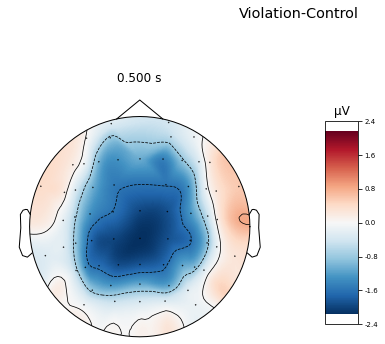

In [8]:
mne.viz.plot_evoked_topomap(mne.grand_average(diff_waves), 
                            times=.500, average=0.200, 
                            title=contrast,
                            size=3
                           )
plt.show()

We can add a few enhancements to the plot to make it more interpretable:
- The `show_names` kwarg tells the function to plot the names of each channel rather than just dots at each location.
- The `contours=False` kwarg turns off the dashed contour lines you can see above. This is a matter of personal preference, however I feel that these are like non-continuous colour scales, in that they provide visual indicators of discontinuous "steps" in the scalp electrical potential values, when in fact these vary smoothly and continuously. 
- We increase the `size` to make the channel labels a bit easier to read (unfortunately the function doesn't provide a kwarg to adjust the font size of these).

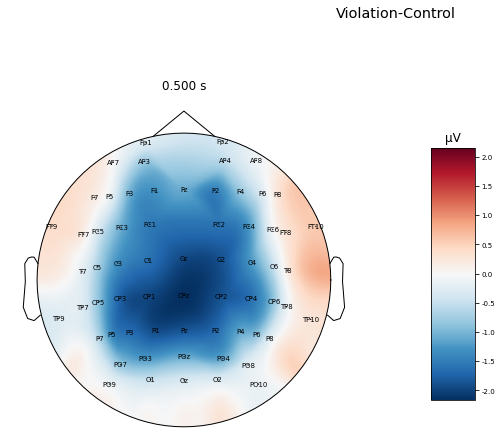

In [9]:
mne.viz.plot_evoked_topomap(mne.grand_average(diff_waves), 
                            times=.500, average=0.200, 
                            title=contrast,
                            show_names=True,
                            contours=False,
                            size=4
                           );

## Statistical analysis

A common approach to testing whether an ERP effect is significant is to perform a *t* test between a pair of conditions, on the ERP data averaged over a time period of interest and at one or a few electrodes. Ideally, the experimenter should have an *a priori* (i.e., defined prior to running the experiment) hypothesis regarding the time window and electrodes at which the ERP component and experimental effect of interest would be largest. In the present case, we predicted an N400, which we knew from previous studies with similar stimuli would likely be largest between 400–600 ms, at electrode Pz. 

In this case, we will use the `ttest_1samp()` function from SciPy's `stats` module. This tests whether a set of values are different from zero. So we use as input the *Violation-Control* differences for each participant, since if they are significantly different from zero, that will be evidence for a difference in amplitude between these two conditions. 

So here we first compute the average over the 400–600 ms time window, for each participant, at electrode Pz, and store these in a NumPy array on which we then perform the *t* test. We create the NumPY array in a single line of code, but it's a fairly complex one:
- we use list comprehension to loop over each participant (`for e in diff_waves`)
- for each participant's `Evoked` object, we use the `.get_data()` method to extract the ERP data
    - we use the `picks` kwarg to specify which electrode(s) we want. In this cases, we specify a single electrode, however we could pass a list of several electrodes if we wanted.
    - we use the `tmin` and `tmax` kwargs to specify the time range over which we want to extract the ERP data
- The result of `get_data` will be a NumPy array of values at each time point in the time range we specified. We apply `np.mean()` to the result of `get_data`, to average across the 400-600 ms time window. We pass the `axis=1` kwarg because the NumPy array will be 2D, with a row for each electrode (in this case, only 1 row), and columns for time. So `axis=1` tells `np.mean()` to average over columns (axis 1; time) and not rows (axis 0; electrodes).
- Since we used list comprehension to loop across participants, we end up with a list of NumPy arrays (one for each participant). Thus the outermost (last applied) function below is `np.array()` to convert the list of values from each participant to a NumPy array, because `ttest_1samp()` requires a NumPy array as input.

In [17]:
evoked_data = np.array([np.mean(e.get_data(picks='Pz', tmin=.400, tmax=.600), axis=1) for e in diff_waves])

Now we perform the *t*-test. Note that `ttest_1samp()` produces NumPy arrays for its outputs (which here we assign to `t` and `pval`), even when we only performed one *t*-test. So when we print the results on the last line, we need to use `t[0]` and `p[0]` rather than simply `t` and `p`.

In [17]:
from scipy import stats 

t, pval = stats.ttest_1samp(evoked_data, 0)
print('Difference t = ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Difference t =  -2.93 p =  0.0071


## Permutation *t*-test

Another approach is to perform a *t* test at *every* electrode, so that we can visualize a statistical map of values across the scalp. This has the advantage of potentially revealing the true scalp distribution of an experimental effect, rather than being limited to the channel(s) predicted a priori to show the effect. 




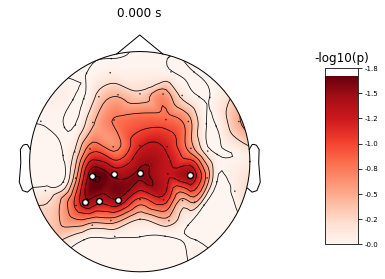

In [21]:
from mne.stats import permutation_t_test

evoked_data = np.array([np.mean(e.get_data(tmin=.400, tmax=.600), axis=1) for e in diff_waves])

n_permutations = 50000
T0, p_values, H0 = permutation_t_test(evoked_data, n_permutations)

evoked = mne.EvokedArray(-np.log10(p_values)[:, np.newaxis],
                         evokeds[conditions[0]][0].info, tmin=0.)

mask = p_values[:, np.newaxis] <= 0.05

evoked.plot_topomap(times=[0], scalings=1,
                    time_format=None, 
                    cmap='Reds', 
                    vmin=0., vmax=np.max,
                    units='-log10(p)', cbar_fmt='-%0.1f', 
                    mask=mask, 
                    size=3, show_names=lambda x: x[4:] + ' ' * 20,
                    time_unit='s')
plt.show()

## Multiple comparison correction
However, this increases our risk of false positives (Type I error). This is because when we perform a *t* test and use the resulting *p* value to determine statistical significance, we typically pick a threshold for significance (alpha) based on the probability of finding a result by chance, if no experimental effect were actually present. In other words, if we use an alpha of .05, this means there is on average a 5% probability of finding that result by chance.  However, that is based on the assumption that we ran only one statistical test. If we run multiple statistical tests, and use *p* ≤ .05 as our threshold, then we increase the odds of finding at least one "significant" result by chance. Most intuitively, if we perform 100 statistical tests and use *p* ≤ .05 on each, then we are likely to end up with 5 of those results being incorrect (5/100 = 5%).

In the present data we have data from 64 electrodes for each participant. One way to correct for multiple comparisons is the **Bonferroni** method, which involves simply dividing the desired alpha value for the experiment (i.e., across all tests) by the number of tests. For this data set that would mean $.05 / 64 = 0.00078$. However, the Bonferroni correction assumes that each statistical test is independent of the others, which is not true for multiple channels of EEG data — nearby channels can be predicted to have similar values, since they are measuring activity from nearby scalp locations. THere are several alternative ways of controlling for multiple comparisons. One is to perform a **permutation** t